# Differential Expression Analysis

The differential expression analysis aims at identifying the genes whose expression levels change between two sample groups. For the differential expression (DE) analysis, we use R package Limma as part of a customised expression pipeline.

At this point, expression and clinical datasets are expected to be clean/preprocessed, containing the same samples and in the same order and ready to use in limma. Do a previous preprocessing if needed.

### Read clinical and expression datasets. GSE48350

To have an idea on how the data look like. Not neccesary if you are providing paths to these datasets in the DE step.

In [1]:
clinicalset=read.table("/mnt/data/GeneExpression/input/clinicalset.GSE48350",stringsAsFactors=T)
dim(clinicalset)
head(clinicalset)

[1] 247   6

,Region,Age,Sex,Status,ApoE,APOEgroup
,<fct>,<int>,<fct>,<fct>,<int>,<fct>
GSM1176196,entorhinalcortex,76,female,Case,33,group3
GSM1176197,entorhinalcortex,86,female,Control,44,group4
GSM1176198,entorhinalcortex,82,female,Case,34,group4
GSM1176199,entorhinalcortex,85,female,Case,23,group2
GSM1176200,entorhinalcortex,90,female,Case,34,group4
GSM1176201,entorhinalcortex,90,female,Case,34,group4


In [2]:
unique(clinicalset$Region)

[1] entorhinalcortex     hippocampus          postcentralgyrus    
[4] superiorfrontalgyrus
4 Levels: entorhinalcortex hippocampus ... superiorfrontalgyrus

In [3]:
# expression data obtained from CEL
expression=read.table("/mnt/data/GeneExpression/output/GSE48350/expression_df",check.names = F,header=T)
dim(expression)
head(expression,n=3)

[1] 54675   253

,GSM1176196,GSM1176197,GSM1176198,GSM1176199,GSM1176200,GSM1176201,GSM1176202,GSM1176203,GSM1176204,GSM1176205,...,GSM300331,GSM300332,GSM300333,GSM300335,GSM300338,GSM300339,GSM300340,GSM300341,GSM318840,GSM350078
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1007_s_at,12.040740,11.173363,11.805107,11.520710,11.554977,11.238944,11.924660,11.467062,11.828813,10.403868,...,10.746467,11.263029,11.587320,10.647399,10.739888,11.334689,11.032435,10.514415,10.909077,10.610349
1053_at,6.702574,6.369982,6.232879,6.253487,6.286031,6.524358,6.488864,6.704865,6.500081,6.512391,...,6.826001,6.411964,6.308492,6.780958,6.617161,6.570866,6.752661,6.717355,6.313379,6.442135
117_at,6.097215,5.893449,6.257163,6.211781,6.229210,5.807598,6.338025,6.074785,6.161630,6.061308,...,5.780972,5.959948,6.002889,5.907806,5.916647,5.647911,5.610944,5.999280,6.263555,5.622806


**Note: It is very important that clinical and expression datasets have the same samples and maintain the same order. Check for this if working with the two dataset separated, or merge them and work with the merged dataframe.** rownames(clinicalset) or sample name/ID column must be in the same order as colnames(expressionset)

***or use ReadAffy in the previous step and start this tutorial with a single dataset.**

In [4]:
# keep the expression values for those samples in the clinical dataset
expression=expression[, rownames(clinicalset)]
dim(expression)

[1] 54675   247

In [5]:
table(colnames(expression) == rownames(clinicalset))


TRUE 
 247 

**Suggested function to keep the same samples in both datasets and in the same order.** It is very useful for heatmaps to create rownames in the expressionset as a combination of conditions from the clinicalset.

In [7]:
# Keep the same samples in both datasets and in the same order
# 1st param: clinical dataframe
# 2nd param: expression dataframe
# returns a list containing the new clinicalset as first element and new expression set as the second element
# optional: create rownames in expressionset as a combination of conditions from clinicalset. Very useful for heatmaps in DE
keepCommonSamplesDF_function<-function(clinicalset,expression.df){  
    merged.df=merge(t(expression.df),clinicalset,by= "row.names")
    # optional - customise
    rownames(merged.df)<-paste(merged.df$Row.names,merged.df$Status,merged.df$APOEgroup,sep="_")
    ncols<-ncol(merged.df)-ncol(clinicalset) # remove columns from clinical data, bear in mind the clinical.match column
    new.expr<-t(merged.df[, 2:ncols] ) # 1st column is Row.names that merge command creates
    from=ncols+1
    to=dim(merged.df)[2]
    new.clinicalset<-merged.df[, from:to]
    return(list(new.clinicalset,new.expr))
}

In [8]:
# call keepCommonSamplesDF function to get clinical and expression sets containing matching samples
sets=keepCommonSamplesDF_function(clinicalset,expression) 
clinicalset.common=sets[[1]]
dim(clinicalset.common)
expr.common=sets[[2]]
dim(expr.common)

[1] 247   6

[1] 54675   247

Check that the datasets are correct and keepCommonSamplesDF function fits your needs.

In [9]:
head(clinicalset.common,n=3)
head(expr.common,n=3)

,Region,Age,Sex,Status,ApoE,APOEgroup
,<fct>,<int>,<fct>,<fct>,<int>,<fct>
GSM1176196_Case_group3,entorhinalcortex,76,female,Case,33,group3
GSM1176197_Control_group4,entorhinalcortex,86,female,Control,44,group4
GSM1176198_Case_group4,entorhinalcortex,82,female,Case,34,group4


,GSM1176196_Case_group3,GSM1176197_Control_group4,GSM1176198_Case_group4,GSM1176199_Case_group2,GSM1176200_Case_group4,GSM1176201_Case_group4,GSM1176202_Case_group4,GSM1176203_Case_group4,GSM1176204_Case_group4,GSM1176205_Case_group3,...,GSM300331_Control_group2,GSM300332_Control_group4,GSM300333_Control_group4,GSM300335_Control_group4,GSM300338_Control_group3,GSM300339_Control_group3,GSM300340_Control_group3,GSM300341_Control_group3,GSM318840_Control_group3,GSM350078_Control_group4
1007_s_at,12.040740,11.173363,11.805107,11.520710,11.554977,11.238944,11.924660,11.467062,11.828813,10.403868,...,10.746467,11.263029,11.587320,10.647399,10.739888,11.334689,11.032435,10.514415,10.909077,10.610349
1053_at,6.702574,6.369982,6.232879,6.253487,6.286031,6.524358,6.488864,6.704865,6.500081,6.512391,...,6.826001,6.411964,6.308492,6.780958,6.617161,6.570866,6.752661,6.717355,6.313379,6.442135
117_at,6.097215,5.893449,6.257163,6.211781,6.229210,5.807598,6.338025,6.074785,6.161630,6.061308,...,5.780972,5.959948,6.002889,5.907806,5.916647,5.647911,5.610944,5.999280,6.263555,5.622806


### Differential Expression with Limma

Limma is  a  package  for  the  analysis  of  gene  expression  data  arising  from  microarray  or  RNA-seq technologies

In [72]:
# Import differential expression functions to use the customised anotation function
source("/home/guess/scripts/diffExpressionPipeline.R")

In [14]:
library(limma)
library(grid)
library(gridExtra)
library(ggplot2)

#### prepare limma sets with covariates

In [100]:
model.matrix=model.matrix(~0+Status+Age+Sex,data = clinicalset.common)
colnames(model.matrix)=c("case","control","age","sexMale")
head(model.matrix)

,case,control,age,sexMale
GSM1176196_Case_group3,1,0,76,0
GSM1176197_Control_group4,0,1,86,0
GSM1176198_Case_group4,1,0,82,0
GSM1176199_Case_group2,1,0,85,0
GSM1176200_Case_group4,1,0,90,0
GSM1176201_Case_group4,1,0,90,0


In [101]:
#design.matrix <- sapply(design_matrix, as.numeric)
contrast.matrix.cov <- makeContrasts(case - control, levels = model.matrix)
set.seed(1)
head(contrast.matrix.cov)

,case - control
case,1
control,-1
age,0
sexMale,0


In [102]:
# This code fits the linear model, smooths the standard errors and displays the top 10 genes for case versus control comparison.
fit.cov <- lmFit(expr.common, model.matrix)
fit.cov <- contrasts.fit(fit.cov, contrast.matrix.cov)
fit.cov <- eBayes(fit.cov)
    
toplist.cov=topTable(fit.cov,sort.by="P",confint=TRUE)
toplist.cov

,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
223213_s_at,0.2769054,0.2029047,0.3509060,9.249143,7.370291,2.576587e-12,1.408749e-07,17.30147
205022_s_at,0.2516586,0.1798411,0.3234760,8.775622,6.901927,4.327188e-11,1.182945e-06,14.66539
214306_at,-0.3749945,-0.4847104,-0.2652786,8.030548,-6.731998,1.169708e-10,2.131793e-06,13.73701
235850_at,-0.4511898,-0.5867963,-0.3155833,8.220935,-6.553412,3.268719e-10,3.688089e-06,12.77820
212117_at,0.3031314,0.2119479,0.3943149,9.105397,6.547918,3.372738e-10,3.688089e-06,12.74899
201938_at,0.3377538,0.2353623,0.4401453,11.712996,6.497181,4.500558e-10,4.101133e-06,12.47996
244287_at,0.2030165,0.1398555,0.2661775,8.594264,6.330981,1.145727e-09,8.826050e-06,11.60896
214801_at,-0.2419455,-0.3175234,-0.1663676,7.416809,-6.305385,1.321144e-09,8.826050e-06,11.47623
227909_at,-0.4301799,-0.5650423,-0.2953175,10.616219,-6.282724,1.498252e-09,8.826050e-06,11.35904


In [103]:
# DE summary
summary(decideTests(fit.cov))

       case - control
Down             3972
NotSig          47564
Up               3139

In [104]:
alltable.cov=topTable(fit.cov,sort.by="P",n=Inf,confint=TRUE)
write.table(alltable.cov,"/mnt/data/GeneExpression/output/GSE48350/limma_covariates_results")

In [105]:
length(intersect(rownames(alltable[1:200,]),rownames(alltable.cov[1:200,])))

[1] 104

#### Annotate limma result

Translate probes to gene symbols using the custom annotate_function.

In [107]:
# call annotate_function to translate probeIDs to gene IDs
alltable.annot<-annotate_function(alltable.cov,platform = "570")
write.table(alltable.annot,"/mnt/data/GeneExpression/output/GSE48350/limma_cov_results_annot")
head(alltable.annot,n=10)


 dim alltable annotated  21755 11 


,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B,platform,gene_id,organism
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>
ZHX1,0.2769054,0.2029047,0.3509060,9.249143,7.370291,2.576587e-12,1.408749e-07,17.30147,GPL570,11244,Homo sapiens
FOXN3,0.2516586,0.1798411,0.3234760,8.775622,6.901927,4.327188e-11,1.182945e-06,14.66539,GPL570,1112,Homo sapiens
OPA1,-0.3749945,-0.4847104,-0.2652786,8.030548,-6.731998,1.169708e-10,2.131793e-06,13.73701,GPL570,4976,Homo sapiens
FAM162A,-0.4511898,-0.5867963,-0.3155833,8.220935,-6.553412,3.268719e-10,3.688089e-06,12.77820,GPL570,26355,Homo sapiens
RHOQ,0.3031314,0.2119479,0.3943149,9.105397,6.547918,3.372738e-10,3.688089e-06,12.74899,GPL570,23433,Homo sapiens
CDK2AP1,0.3377538,0.2353623,0.4401453,11.712996,6.497181,4.500558e-10,4.101133e-06,12.47996,GPL570,8099,Homo sapiens
SREK1,0.2030165,0.1398555,0.2661775,8.594264,6.330981,1.145727e-09,8.826050e-06,11.60896,GPL570,140890,Homo sapiens
TOR1AIP2,-0.2419455,-0.3175234,-0.1663676,7.416809,-6.305385,1.321144e-09,8.826050e-06,11.47623,GPL570,163590,Homo sapiens
SMIM10L2B,-0.4301799,-0.5650423,-0.2953175,10.616219,-6.282724,1.498252e-09,8.826050e-06,11.35904,GPL570,644596,Homo sapiens


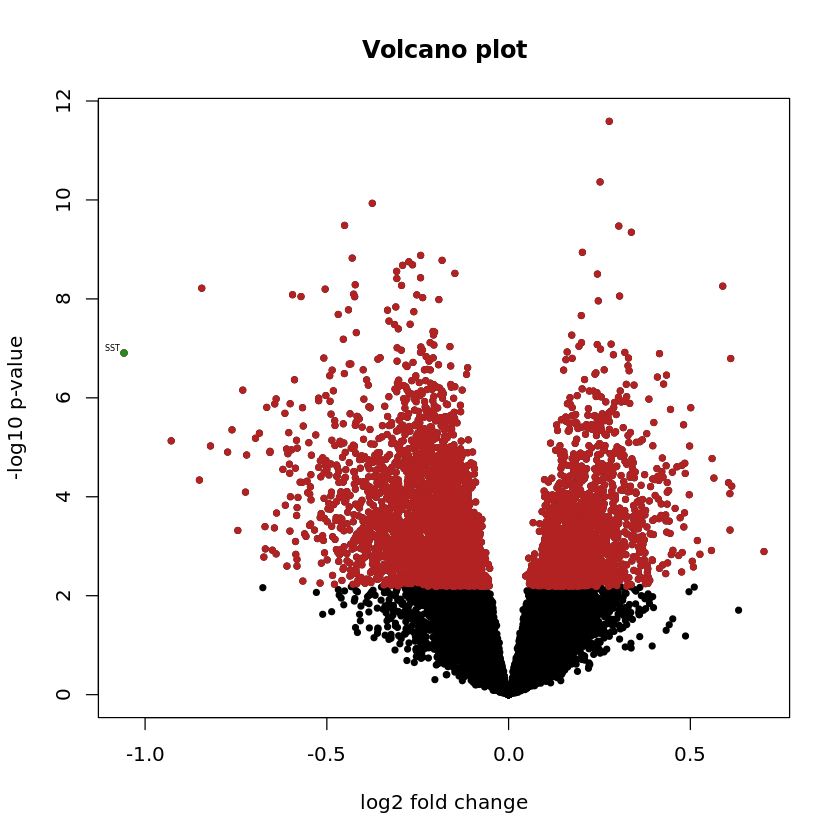

In [108]:
# volcano plot
with(alltable.annot, plot(logFC, -log10(P.Value), pch=20, main="Volcano plot", ylab="-log10 p-value", xlab="log2 fold change"))

# Add colored points: red if padj<0.05, orange of log2FC>1, green if both)
with(subset(alltable.annot, adj.P.Val<.05 ), points(logFC, -log10(P.Value), pch=20, col="firebrick"))
with(subset(alltable.annot, abs(logFC)>1), points(logFC, -log10(P.Value), pch=20, col="darkorange4"))
set<-subset(alltable.annot, adj.P.Val<.05 & abs(logFC)>1)
with(set, points(logFC, -log10(P.Value), pch=20, col="forestgreen"))

# Label points with the textxy function from the calibrate plot
library(calibrate)
with(set, textxy(logFC, -log10(P.Value), labs=rownames(set), cex=.4))
# if I use as labels rownames(alltable.annot) it is ilegible

A **volcano plot** is a type of scatterplot that shows statistical significance (P value) versus magnitude of change (fold change). It enables quick visual identification of genes with large fold changes that are also statistically significant. These may be the most biologically significant genes. In a volcano plot, the most upregulated genes are towards the right, the most downregulated genes are towards the left, and the most statistically significant genes are towards the top.


**Heatmap**

In [109]:
heatmapset<-expr.common[rownames(alltable.cov[1:50 ,]) ,] #top 50 DE probes
dim(heatmapset)
head(heatmapset)

[1]  50 247

,GSM1176196_Case_group3,GSM1176197_Control_group4,GSM1176198_Case_group4,GSM1176199_Case_group2,GSM1176200_Case_group4,GSM1176201_Case_group4,GSM1176202_Case_group4,GSM1176203_Case_group4,GSM1176204_Case_group4,GSM1176205_Case_group3,...,GSM300331_Control_group2,GSM300332_Control_group4,GSM300333_Control_group4,GSM300335_Control_group4,GSM300338_Control_group3,GSM300339_Control_group3,GSM300340_Control_group3,GSM300341_Control_group3,GSM318840_Control_group3,GSM350078_Control_group4
223213_s_at,9.598518,9.304492,9.791100,9.402253,9.711890,9.175245,9.922942,9.185615,9.427048,9.064332,...,9.045234,9.266761,9.662584,9.419809,8.934405,9.057459,8.889395,9.066250,9.320821,9.303844
205022_s_at,8.739579,8.713697,9.698152,8.881999,9.200485,9.193859,8.817739,8.616595,9.053833,8.733665,...,8.854385,8.941708,9.003702,8.874316,8.351594,8.188905,8.764557,8.604772,9.187803,8.669213
214306_at,7.420201,8.532560,7.099080,7.738010,7.008538,7.976117,7.410730,8.293716,7.603354,7.919064,...,8.032827,7.867592,8.067710,8.114076,8.152951,8.224680,8.055260,7.739549,8.157346,8.817467
235850_at,7.397078,8.910719,7.150663,8.435400,7.199719,8.075242,7.843204,8.235027,7.939094,8.433164,...,8.408173,7.684807,8.253979,8.341510,8.593775,8.666516,8.584986,8.533905,8.195538,9.082909
212117_at,9.510987,9.130704,9.763627,9.397725,9.770689,9.484685,9.628879,9.275076,9.373520,8.914772,...,9.357319,9.394030,9.557637,9.532954,8.548540,8.860262,8.906195,8.877642,9.587330,8.765051
201938_at,12.185673,11.938630,12.466682,12.052483,12.370664,11.849642,12.177611,11.702093,12.249614,11.281894,...,11.685943,11.916020,12.022183,11.885020,11.004713,11.710860,11.182828,11.033051,11.761167,11.548087


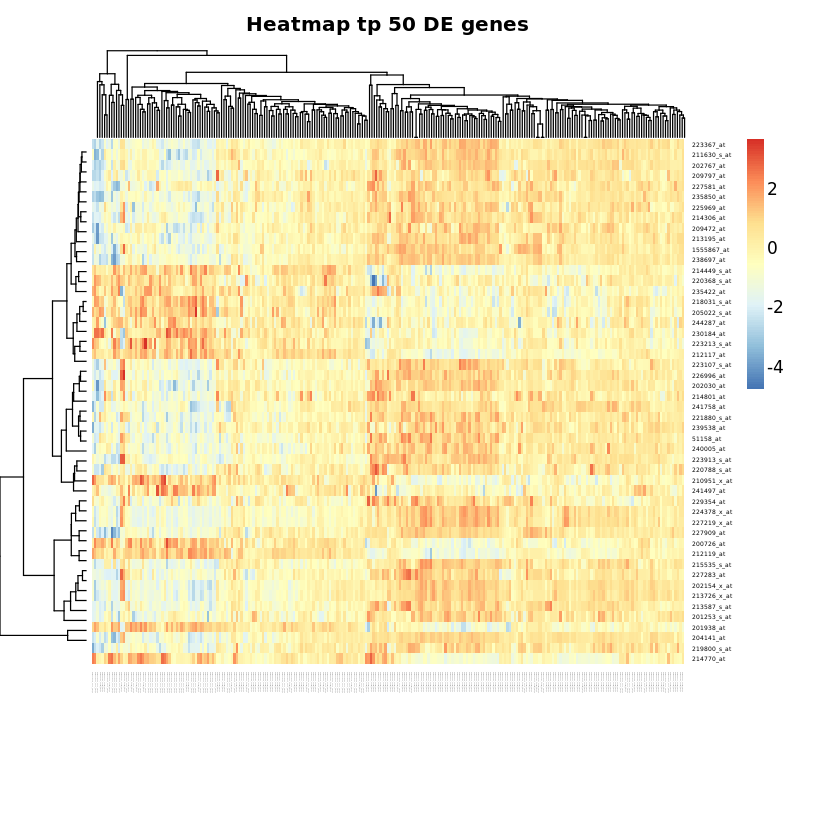

In [110]:
aheatmap(as.matrix(heatmapset),Rowv = TRUE , Colv = TRUE ,distfun = "euclidean", hclustfun = "average",scale = "row",main="Heatmap tp 50 DE genes")

In heat maps the data is displayed in a grid where each row represents a gene and each column represents a sample. The colour and intensity of the boxes is used to represent changes (not absolute values) of gene expression. 